# Exercise 2 - Heart Disease with KNN #

Heart disease data set: https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Objective: to predict heart disease in patients. 

1) Get to know your data, start out by data exploration. Summarize your finding. 

2) Divide the data into training set and test set randomly with ratio 80:20.  Make prediction based on 1-nearest neighbor. What is the error rate of this approach?  Report the confusion matrix. 

3) Use different values for K, what is the optimal value of K from your experiments? 

Report the error rate of the optimal K value and its confusion matrix. Is there any improvement (by how much) over 1-nearest neighbor? 

### NOTE: The Cleveland data file is corrupt. We will add in the processed version when we've dealt with the other files. ###

The original dataset has a really funky format. It is space separated and each record is several rows:

In [1]:
lines_list = []
files = ['/Users/mbusch/OneDrive - Regis University/MSDS/680/Week_2/Exercise/hungarian.data',
        '/Users/mbusch/OneDrive - Regis University/MSDS/680/Week_2/Exercise/long-beach-va.data',
        '/Users/mbusch/OneDrive - Regis University/MSDS/680/Week_2/Exercise/switzerland.data']
for file in files:
    with open(file) as infile:
        for line in infile:
            if line.strip():    # strip() leaves blank if only newline -- skip these
                lines_list.append(line.strip())
    

lines_list[:20]


['1254 0 40 1 1 0 0',
 '-9 2 140 0 289 -9 -9 -9',
 '0 -9 -9 0 12 16 84 0',
 '0 0 0 0 150 18 -9 7',
 '172 86 200 110 140 86 0 0',
 '0 -9 26 20 -9 -9 -9 -9',
 '-9 -9 -9 -9 -9 -9 -9 12',
 '20 84 0 -9 -9 -9 -9 -9',
 '-9 -9 -9 -9 -9 1 1 1',
 '1 1 -9. -9. name',
 '1255 0 49 0 1 0 0',
 '-9 3 160 1 180 -9 -9 -9',
 '0 -9 -9 0 11 16 84 0',
 '0 0 0 0 -9 10 9 7',
 '156 100 220 106 160 90 0 0',
 '1 2 14 13 -9 -9 -9 -9',
 '-9 -9 -9 -9 -9 -9 -9 11',
 '20 84 1 -9 -9 2 -9 -9',
 '-9 -9 -9 -9 -9 1 1 1',
 '1 1 -9. -9. name']

In [2]:
len(lines_list)

6170

Looks like a new record every 10 lines. If we can count on that it will make restructuring easy.

Let's strip that newline character and replace spaces with commas.

In [3]:
cleaned_lines = []
for line in lines_list:
    cleaned_lines.append(line.replace(' ', ','))

In [4]:
cleaned_lines[0:10]

['1254,0,40,1,1,0,0',
 '-9,2,140,0,289,-9,-9,-9',
 '0,-9,-9,0,12,16,84,0',
 '0,0,0,0,150,18,-9,7',
 '172,86,200,110,140,86,0,0',
 '0,-9,26,20,-9,-9,-9,-9',
 '-9,-9,-9,-9,-9,-9,-9,12',
 '20,84,0,-9,-9,-9,-9,-9',
 '-9,-9,-9,-9,-9,1,1,1',
 '1,1,-9.,-9.,name']

In [5]:
len(cleaned_lines)

6170

6170 is an even multiple of 10 so probably no blank lines.

In [6]:
#tee(cleaned_lines, len(cleaned_lines)/10)
cleaned_lines[-2], cleaned_lines[-1]

('1,1,1,2,1,1,1,1', '1,1,70,-9.,name')

I generally don't like resorting to using a counter variable and range() in Python. That's what iterators are for but I can't find a better, more "Pythonic" way to join these records.

In [7]:
n = 10
[cleaned_lines[i:i + n] for i in range(0, len(cleaned_lines), n)]

[['1254,0,40,1,1,0,0',
  '-9,2,140,0,289,-9,-9,-9',
  '0,-9,-9,0,12,16,84,0',
  '0,0,0,0,150,18,-9,7',
  '172,86,200,110,140,86,0,0',
  '0,-9,26,20,-9,-9,-9,-9',
  '-9,-9,-9,-9,-9,-9,-9,12',
  '20,84,0,-9,-9,-9,-9,-9',
  '-9,-9,-9,-9,-9,1,1,1',
  '1,1,-9.,-9.,name'],
 ['1255,0,49,0,1,0,0',
  '-9,3,160,1,180,-9,-9,-9',
  '0,-9,-9,0,11,16,84,0',
  '0,0,0,0,-9,10,9,7',
  '156,100,220,106,160,90,0,0',
  '1,2,14,13,-9,-9,-9,-9',
  '-9,-9,-9,-9,-9,-9,-9,11',
  '20,84,1,-9,-9,2,-9,-9',
  '-9,-9,-9,-9,-9,1,1,1',
  '1,1,-9.,-9.,name'],
 ['1256,0,37,1,1,0,0',
  '-9,2,130,0,283,-9,-9,-9',
  '0,-9,-9,1,11,21,84,0',
  '0,0,0,0,100,10,-9,5',
  '98,58,180,100,130,80,0,0',
  '0,-9,17,14,-9,-9,-9,-9',
  '-9,-9,-9,-9,-9,-9,-9,11',
  '26,84,0,-9,-9,-9,-9,-9',
  '-9,-9,-9,-9,-9,1,1,1',
  '1,1,-9.,-9.,name'],
 ['1257,0,48,0,1,1,1',
  '-9,4,138,0,214,-9,-9,-9',
  '0,-9,-9,0,9,21,84,0',
  '0,0,0,0,50,5,4,4',
  '108,54,210,106,138,86,1,0',
  '1.5,2,19,22,-9,-9,-9,-9',
  '-9,-9,-9,-9,-9,-9,-9,9',
  '30,84,3,-9

OK, that gives sub-lists that we could use the join() function on. 

In [8]:
records_list = [cleaned_lines[i:i + n] for i in range(0, len(cleaned_lines), n)]

At this point we have a list of lists and the join() function on string joins all the elements in a list. If we iterate through records_list, then each element will be a list to join into a record.

In [9]:
[','.join(record) for record in records_list]

['1254,0,40,1,1,0,0,-9,2,140,0,289,-9,-9,-9,0,-9,-9,0,12,16,84,0,0,0,0,0,150,18,-9,7,172,86,200,110,140,86,0,0,0,-9,26,20,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,12,20,84,0,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,1,1,1,1,1,-9.,-9.,name',
 '1255,0,49,0,1,0,0,-9,3,160,1,180,-9,-9,-9,0,-9,-9,0,11,16,84,0,0,0,0,0,-9,10,9,7,156,100,220,106,160,90,0,0,1,2,14,13,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,11,20,84,1,-9,-9,2,-9,-9,-9,-9,-9,-9,-9,1,1,1,1,1,-9.,-9.,name',
 '1256,0,37,1,1,0,0,-9,2,130,0,283,-9,-9,-9,0,-9,-9,1,11,21,84,0,0,0,0,0,100,10,-9,5,98,58,180,100,130,80,0,0,0,-9,17,14,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,11,26,84,0,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,1,1,1,1,1,-9.,-9.,name',
 '1257,0,48,0,1,1,1,-9,4,138,0,214,-9,-9,-9,0,-9,-9,0,9,21,84,0,0,0,0,0,50,5,4,4,108,54,210,106,138,86,1,0,1.5,2,19,22,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,9,30,84,3,-9,2,-9,-9,2,-9,-9,-9,2,-9,1,1,1,1,1,-9.,-9.,name',
 '1258,0,54,1,1,0,1,-9,3,150,0,-9,-9,-9,-9,0,-9,-9,0,7,25,84,0,0,1,1,0,25,2,-9,3,122,74,130,100,150,90,0,1,0,-9,13,9,-9,-9,-9,-

In [10]:
records = [','.join(record) for record in records_list]

Now, every element of records is a string

In [11]:
import pandas as pd
hungarian_df = pd.DataFrame(records)

In [12]:
hungarian_df.head()

,0
0,"1254,0,40,1,1,0,0,-9,2,140,0,289,-9,-9,-9,0,-9..."
1,"1255,0,49,0,1,0,0,-9,3,160,1,180,-9,-9,-9,0,-9..."
2,"1256,0,37,1,1,0,0,-9,2,130,0,283,-9,-9,-9,0,-9..."
3,"1257,0,48,0,1,1,1,-9,4,138,0,214,-9,-9,-9,0,-9..."
4,"1258,0,54,1,1,0,1,-9,3,150,0,-9,-9,-9,-9,0,-9,..."


Now we have a DataFrame with one column. Closer, I guess... Let's split those lines on the commas.

In [13]:
records_columns = [record.split(',') for record in records]

In [14]:
hungarian_df = pd.DataFrame(records_columns)

In [15]:
hungarian_df.head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,1254,0,40,1,1,0,0,-9,2,140,...,-9,-9,1,1,1,1,1,-9.,-9.,name
1,1255,0,49,0,1,0,0,-9,3,160,...,-9,-9,1,1,1,1,1,-9.,-9.,name
2,1256,0,37,1,1,0,0,-9,2,130,...,-9,-9,1,1,1,1,1,-9.,-9.,name
3,1257,0,48,0,1,1,1,-9,4,138,...,2,-9,1,1,1,1,1,-9.,-9.,name
4,1258,0,54,1,1,0,1,-9,3,150,...,1,-9,1,1,1,1,1,-9.,-9.,name


In [16]:
hungarian_df.columns

RangeIndex(start=0, stop=76, step=1)

I'd like my column numbers to match up with the data dictionary.

In [17]:
hungarian_df.columns = [x + 1 for x in hungarian_df.columns]


In [18]:
hungarian_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 76 columns):
1     617 non-null object
2     617 non-null object
3     617 non-null object
4     617 non-null object
5     617 non-null object
6     617 non-null object
7     617 non-null object
8     617 non-null object
9     617 non-null object
10    617 non-null object
11    617 non-null object
12    617 non-null object
13    617 non-null object
14    617 non-null object
15    617 non-null object
16    617 non-null object
17    617 non-null object
18    617 non-null object
19    617 non-null object
20    617 non-null object
21    617 non-null object
22    617 non-null object
23    617 non-null object
24    617 non-null object
25    617 non-null object
26    617 non-null object
27    617 non-null object
28    617 non-null object
29    617 non-null object
30    617 non-null object
31    617 non-null object
32    617 non-null object
33    617 non-null object
34    617 non-null object
35    617 n

And that 'name' column is messing us up. 

In [19]:
hungarian_df.groupby([76]).size()

76
name    617
dtype: int64

So, the only value in that column is 'name'. I doubt it is useful. Let's drop it

In [20]:
hungarian_df = hungarian_df.drop(columns=[76])

In [21]:
hungarian_df.apply(pd.to_numeric).head()

,1,2,3,4,5,6,7,8,9,10,...,66,67,68,69,70,71,72,73,74,75
0,1254,0,40,1,1,0,0,-9,2,140,...,-9,-9,-9,1,1,1,1,1,-9.0,-9.0
1,1255,0,49,0,1,0,0,-9,3,160,...,-9,-9,-9,1,1,1,1,1,-9.0,-9.0
2,1256,0,37,1,1,0,0,-9,2,130,...,-9,-9,-9,1,1,1,1,1,-9.0,-9.0
3,1257,0,48,0,1,1,1,-9,4,138,...,-9,2,-9,1,1,1,1,1,-9.0,-9.0
4,1258,0,54,1,1,0,1,-9,3,150,...,-9,1,-9,1,1,1,1,1,-9.0,-9.0


Now the fun part -- according to the docs, only 14 columns are used:

5. Number of Instances: 

        Database:    # of instances:
          Cleveland: 303
          Hungarian: 294
        Switzerland: 123
      Long Beach VA: 200

6. Number of Attributes: 76 (including the predicted attribute)

7. Attribute Information:

   -- Only 14 used
   
      -- 1. #3  (age)       
      -- 2. #4  (sex)       
      -- 3. #9  (cp)        
      -- 4. #10 (trestbps)  
      -- 5. #12 (chol)      
      -- 6. #16 (fbs)       
      -- 7. #19 (restecg)   
      -- 8. #32 (thalach)   
      -- 9. #38 (exang)     
      -- 10. #40 (oldpeak)   
      -- 11. #41 (slope)     
      -- 12. #44 (ca)        
      -- 13. #51 (thal)      
      -- 14. #58 (num)       (the predicted attribute)

### Note: Missing values are filled with -9. ###

Let's make a list of used columns and another of labels.

In [22]:
used_columns = [3,4,9,10,12,16,19,32,38,40,41,44,51,58] 
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol','fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'result']

In [23]:
used_df = hungarian_df[used_columns].apply(pd.to_numeric)

In [24]:
used_df.head()

,3,4,9,10,12,16,19,32,38,40,41,44,51,58
0,40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
1,49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
2,37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
3,48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
4,54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0


In [25]:
used_df.columns = column_names

In [26]:
used_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,result
0,40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
1,49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
2,37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
3,48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
4,54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0


Let's add that Cleveland data now.

In [27]:
print(f'Before Cleveland: {used_df.shape}')
with open('/Users/mbusch/OneDrive - Regis University/MSDS/680/Week_2/Exercise/processed.cleveland.data') as infile:
    cleve_df = pd.read_csv(infile, names=column_names)
used_df = pd.concat([used_df,cleve_df], ignore_index=True)
print(f'After Cleveland: {used_df.shape}')          

Before Cleveland: (617, 14)
After Cleveland: (920, 14)


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

Docs say there are 5 values in our target field but research to date has only distinguished '0' as no heart disease and > 0 has heart disease.

In [29]:
used_df.groupby(['result']).size()

result
0    411
1    196
2    135
3    135
4     43
dtype: int64

Interesting results. According to our data dictionary:

     58 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
So that means our result is categorical and should probably be re-binned as simply 0 and 1.

In [30]:
used_df.loc[used_df['result'] > 1, 'result'] = 1

In [31]:
used_df.groupby(['result']).size()

result
0    411
1    509
dtype: int64

OK, we saw from the info() above that there were no missing values, but let's check anyway.

In [32]:
used_df.isnull().values.any()

False

According to the UCI repository, columns look like this:

**Attribute Information**

1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types**

* Real: 
    * 1, 4, 5, 8, 10, 12
* Ordered:
    * 11,
* Binary: 
    * 2, 6, 9
* Nominal:
    * 7, 3, 13

**Variable to be predicted**

Absence (1) or presence (2) of heart disease 

Let's do some plotting on the features.

result
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

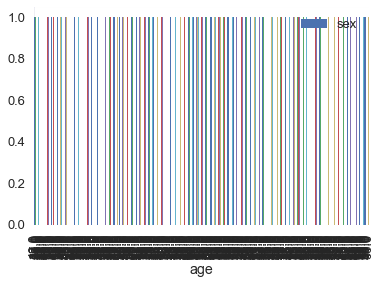

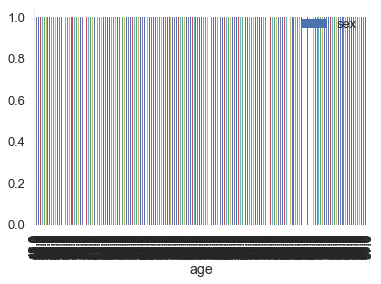

In [55]:
used_df.groupby('result').plot(x='age', y='sex', kind='bar')

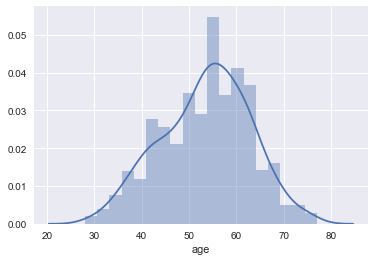

In [33]:
sns.set() # Use Seaborn defaults. Looks nicer.
sns.distplot(used_df.age.dropna())
plt.show()

Not bad. The trestbps, chol, and thalach columns are going to give us trouble since the values are wildly different from the rest of them. Plus, even though they look kind of like continuous values I think it may be more appropriate to make categories. Something to keep in mind. 

Also, thinking about it, we may want to pivot the table on age? trestbps? chol? to make the comparisons work better...

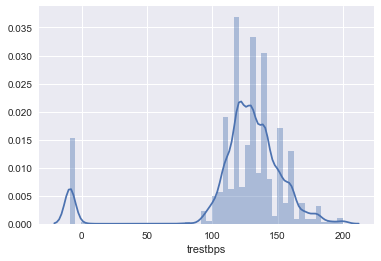

In [34]:
sns.distplot(used_df.trestbps.dropna())
plt.show()

One value below 0. That must have been a missing value. We may have to throw that one out.

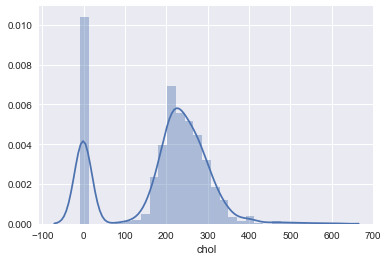

In [35]:
sns.distplot(used_df.chol.dropna())
plt.show()

A zero seems rather implausible. Another one we may want to throw out.


Correlation matrix

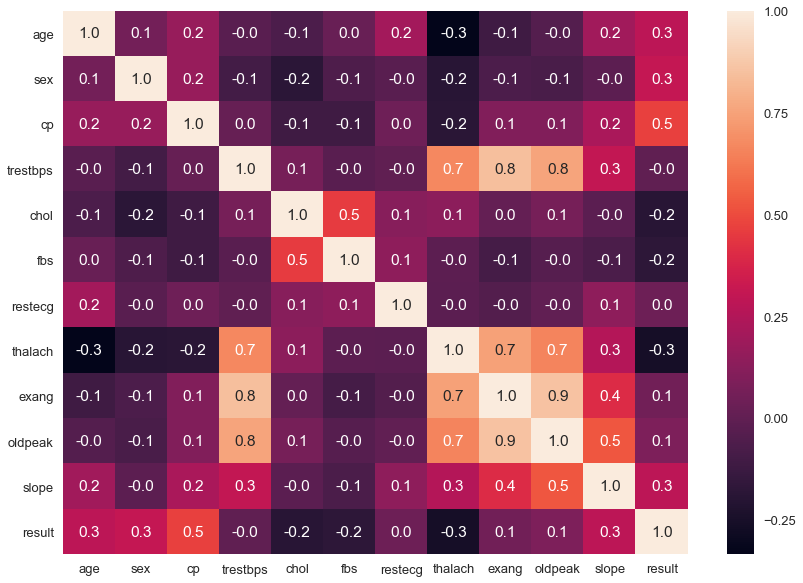

In [47]:
f, ax = plt.subplots(figsize=(14,10))
sns.set_context("talk", font_scale=1.0)
# df = used_df.pivot_table(index='result', columns='age', 'sex', 'cp', 'trestbps', 'chol','fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal' ,  values='age')
sns.heatmap(used_df.corr(), annot=True, fmt=".1f")
plt.show()

Seems to be the highest correlation with the CP (chest pains type) column, but that is a category and should probably be dealt with. 

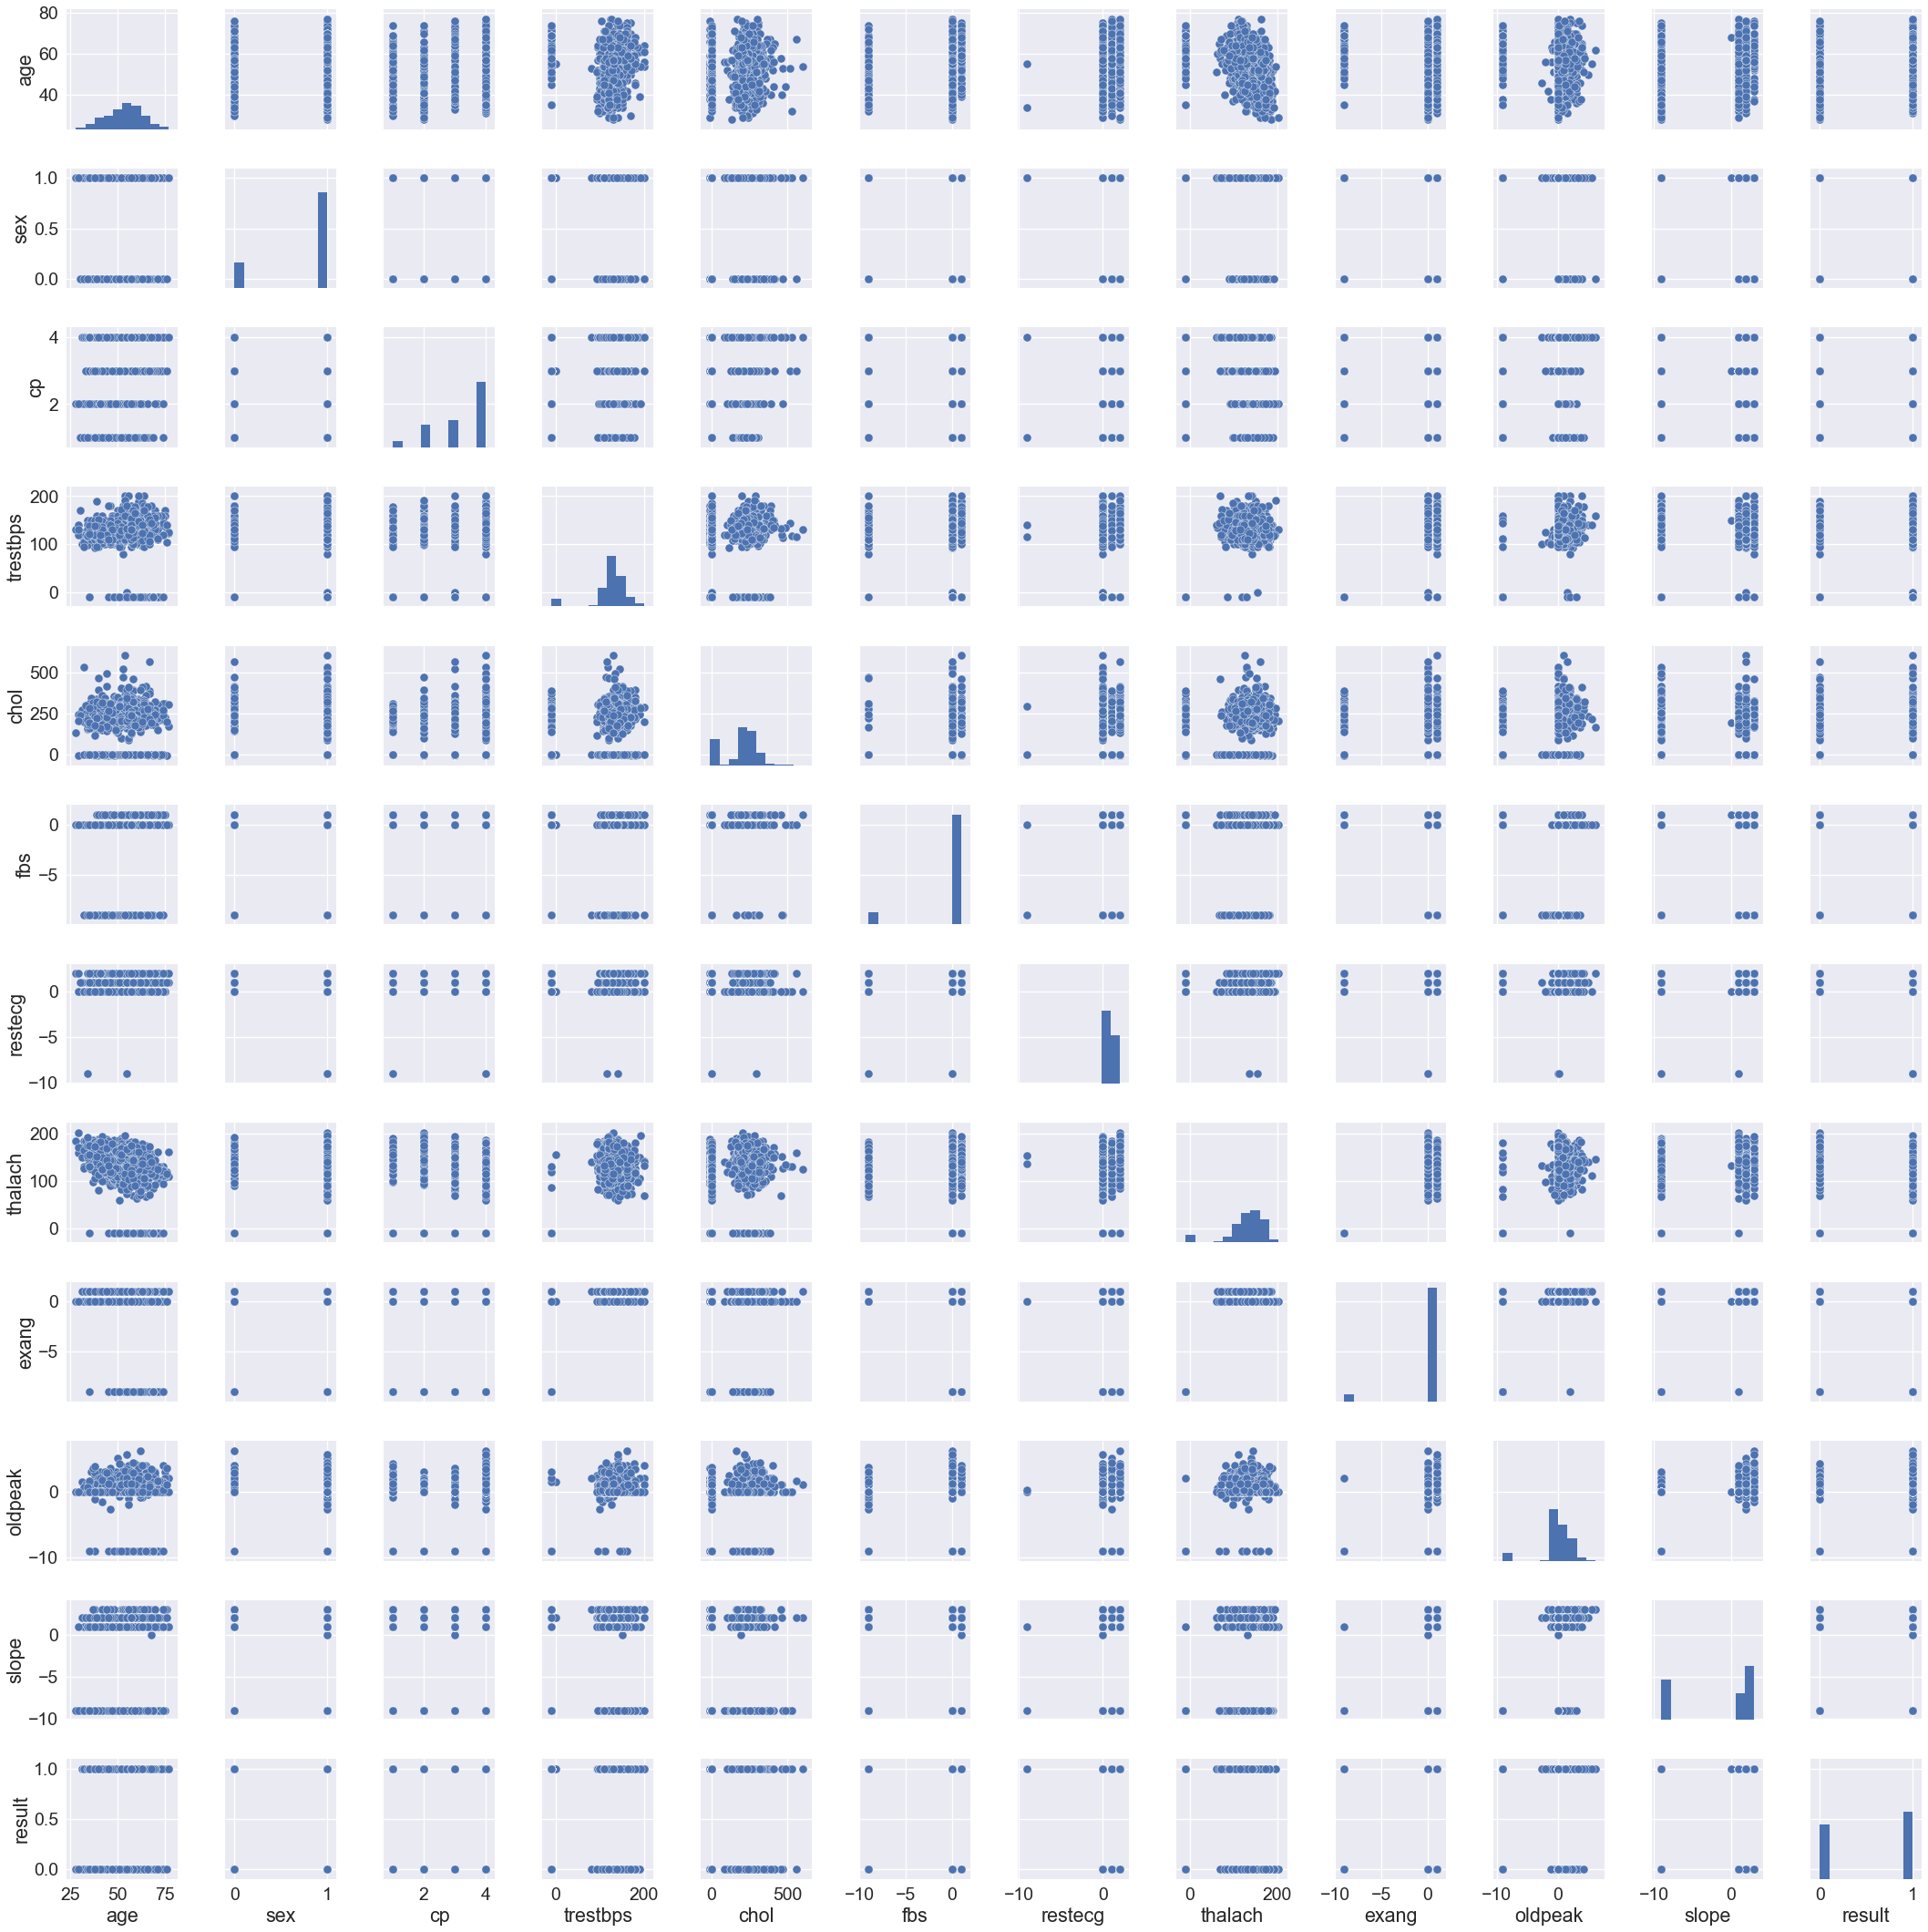

In [37]:
g = sns.pairplot(used_df)
plt.show()

In [56]:
import sklearn-pandas

SyntaxError: invalid syntax (<ipython-input-56-dd411012c83b>, line 1)

SciKit Learn can do a nice, random train-test split for us.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = used_df.result #this is our target column

In [ ]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(used_df, y, test_size=0.2)

In [ ]:
print (X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

OK. That's weird. Age is supposed to the the patient's age in years.

This is our first attempt, and we note that we haven't normalized any of the data.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)